In [1]:
#Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
#Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#Declare base
Base = automap_base()

#Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
#View all of the classes
Base.classes.keys()

['measurement', 'station']

In [8]:
#Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
#Create session
session = Session(engine)

## **Step 1:  Climate Analysis and Exploration**

### **Precipitation Analysis**

In [10]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results

#Calculate the date 1 year ago from the last data point in the database
#Find the latest date in the dataset
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date

('2017-08-23')

In [11]:
#Find date 1 year ago from last date point
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [12]:
#Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_date).\
    order_by(measurement.date).all()

In [13]:
#Save the query results as a Pandas DataFrame and set the index to the date column (dates sorted in query)
precip_df = pd.DataFrame(results, columns=['date', 'precipitation'])
precip_df.set_index('date', inplace=True)
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


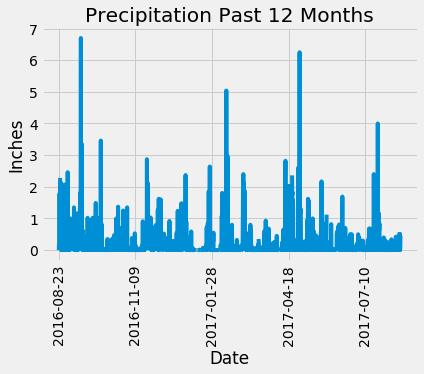

In [14]:
#Plot the data
precip_df.plot(rot=90, legend=False)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Past 12 Months")
plt.show()

In [15]:
#Calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### **Station Analysis**

In [16]:
#Calculate the total number of stations
total_stations = session.query(measurement).group_by(measurement.station).count()
print(f"Total Stations = {total_stations}")

Total Stations = 9


In [17]:
#Find the most active stations
#List stations and observation counts in descending order; Which station has the highest number of observations?
station_counts = session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.tobs).desc()).all()

SC_df = pd.DataFrame(station_counts, columns=['Station', 'Count'])
SC_df.set_index('Station', inplace=True)
SC_df

,Count
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


Station USC00519281 has the highest number of observations.

In [18]:
#For the most active station, calculate the lowest temperature recorded, highest temperature recorded,
#and average temperature.

sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]

station_stats = session.query(*sel).filter(measurement.station == 'USC00519281').all()
stats = list(np.ravel(station_stats))
min_temp = stats[0]
max_temp = stats[1]
avg_temp = round(stats[2],1)

print("Temperature Statistics for Station USC00519281")
print("----------------------------------------------")
print(f"Lowest Temperature Recorded: {min_temp}")
print(f"Highest Temperature Recorded: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Temperature Statistics for Station USC00519281
----------------------------------------------
Lowest Temperature Recorded: 54.0
Highest Temperature Recorded: 85.0
Average Temperature: 71.7


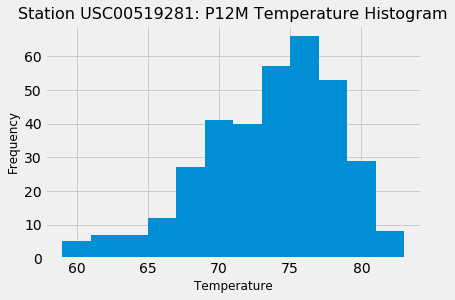

In [19]:
#Retrieve the last 12 months of temperature observations
#Filter by the station with the highest number of observations

temps = session.query(measurement.date, measurement.tobs).filter(measurement.date >= query_date).\
    filter(measurement.station == 'USC00519281').all()

temps_df = pd.DataFrame(temps, columns=['date', 'temperature'])


#Plot the results as a histogram with bins=12
plt.hist(temps_df.temperature, bins=12)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Station USC00519281: P12M Temperature Histogram", fontsize=16)
plt.show()

## **Bonus**

### **Temperature Analysis I**

In [20]:
from scipy import stats
from numpy import mean

In [21]:
#Find average temperature for June across all stations across all available years
June_date_str = "06"
June_tobs = session.query(measurement.tobs).filter(func.strftime("%m", measurement.date) == June_date_str).all()
mean(June_tobs)

74.94411764705882

In [22]:
#Find average temperature for December across all stations across all available years
Dec_date_str = "12"
Dec_tobs = session.query(measurement.tobs).filter(func.strftime("%m", measurement.date) == Dec_date_str).all()
mean(Dec_tobs)

71.04152933421226

In [23]:
#Perform a t-test to determine if these means are statistically significant
stats.ttest_ind(June_tobs, Dec_tobs)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

An independent t-test is used (instead of a paired t-test) since the temperatures are two different groups of cases.
The mean temperatures for June and December are significantly different since the p-value is essentially zero.
We can reject the null hypothesis that the two means are equal.

### **Temperature Analysis II**

In [24]:
#This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
#and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

In [25]:
#Use the function `calc_temps` to calculate the tmin, tavg, and tmax for trip dates using the previous year's data
#for those same dates.
temp_res = calc_temps('2010-06-15', '2010-06-25')
print(temp_res)

[(69.0, 74.82417582417582, 85.0)]


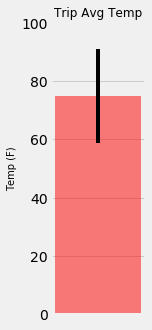

In [26]:
#Plot the results from the previous query as a bar chart. 
#Use "Trip Avg Temp" as the Title
#Use the average temperature for the y value
#Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_list = list(np.ravel(temp_res))
Avg_Temp = temp_list[1]
Min_Temp = temp_list[0]
Max_Temp = temp_list[2]
PTP = Max_Temp - Min_Temp
x_axis = 1

plt.figure(figsize=(1.5,5))
plt.bar(x_axis, Avg_Temp, color='r', alpha=0.5, yerr=PTP, align="center")

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.xaxis.grid()

plt.ylim(0, 100)
plt.ylabel("Temp (F)", fontsize=10)
plt.title("Trip Avg Temp", fontsize=12)
plt.show()

### **Daily Rainfall Average**

In [27]:
#Calculate the total amount of rainfall per weather station for trip dates using the previous year's matching dates.
#Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_dt = '2010-06-15'
end_dt = '2010-06-25'

results = session.query(measurement.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)).\
    filter(measurement.station == station.station).filter(measurement.date >= start_dt).filter(measurement.date <= end_dt).\
    group_by(measurement.station).order_by(func.sum(measurement.prcp).desc()).all()

precip_sum = pd.DataFrame(results, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Total Precip'])
precip_sum.set_index('Station', inplace=True)
precip_sum

,Name,Latitude,Longitude,Elevation,Total Precip
Station,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.14
USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,1.04
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.83
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.31
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.27
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.22
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.19
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.11
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


In [28]:
#Create a query that will calculate the daily normals 
#(i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

In [29]:
#Calculate the daily normals for trip
#Push each tuple of calculations into a list called `normals`

#Set the start and end date of the trip
#Use the start and end date to create a range of dates
#Strip off the year and save a list of %m-%d strings

my_dates = pd.date_range(start='2011-06-15', end='2011-06-25')
my_trip_dates = []
my_trip_dates_md = []
for date in my_dates:
    my_trip_dates.append(date.strftime('%Y-%m-%d'))
    my_trip_dates_md.append(date.strftime('%m-%d'))

normals = []
for d in my_trip_dates_md:
    dly_nrms = daily_normals(d)
    normals.append(dly_nrms)

normals

[[(67.0, 75.40350877192982, 81.0)],
 [(69.0, 75.41379310344827, 81.0)],
 [(68.0, 74.59322033898304, 81.0)],
 [(69.0, 74.60344827586206, 80.0)],
 [(70.0, 75.44067796610169, 82.0)],
 [(68.0, 73.96491228070175, 85.0)],
 [(68.0, 74.75862068965517, 82.0)],
 [(69.0, 75.15789473684211, 81.0)],
 [(68.0, 74.54385964912281, 80.0)],
 [(68.0, 74.96428571428571, 84.0)],
 [(68.0, 74.10344827586206, 80.0)]]

In [30]:
#Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(np.vstack(normals), columns=['Min_Temp', 'Avg_Temp', 'Max_Temp'])
normals_df['Date'] = my_trip_dates
normals_df.set_index('Date', inplace=True)
normals_df

,Min_Temp,Avg_Temp,Max_Temp
Date,,,
2011-06-15,67.0,75.403509,81.0
2011-06-16,69.0,75.413793,81.0
2011-06-17,68.0,74.593220,81.0
2011-06-18,69.0,74.603448,80.0
2011-06-19,70.0,75.440678,82.0
2011-06-20,68.0,73.964912,85.0
2011-06-21,68.0,74.758621,82.0
2011-06-22,69.0,75.157895,81.0
2011-06-23,68.0,74.543860,80.0


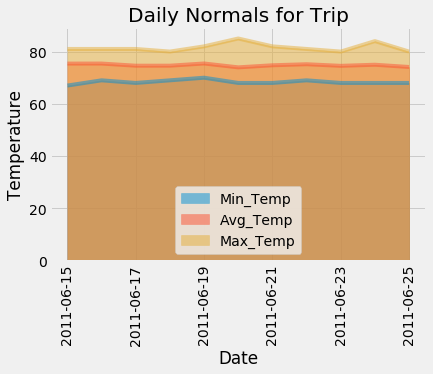

In [31]:
#Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, rot=90)
plt.ylabel("Temperature")
plt.legend(loc='lower center')
plt.title("Daily Normals for Trip")
plt.show()